In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import dask.dataframe as dd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
ps = PorterStemmer()
import sys
sys.setrecursionlimit(5000)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [65]:
dftr = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
dfte = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
y = dftr.iloc[:,2:]
df1 = pd.DataFrame(dftr.iloc[:,1])
df2 = pd.DataFrame(dfte.iloc[:,1])
x=pd.DataFrame(pd.concat([df1,df2]))

In [66]:
print(dftr.shape,dftr.shape,x.shape)
x.index=[a for a in range(0,len(x))]
x.head()

(159571, 8) (159571, 8) (312735, 1)


,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


# Data Analysis

In [67]:
dftr["characters"]=dftr["comment_text"].apply(len)
dftr["words"]=dftr["comment_text"].apply(lambda p:len(nltk.word_tokenize(p)))
dftr["sentences"]=dftr["comment_text"].apply(lambda p:len(nltk.sent_tokenize(p)))

In [68]:
dftr=dftr.iloc[:,[-3,-2,-1,2,3,4,5,6,7]]
dftr.head()

,characters,words,sentences,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,264,49,3,0,0,0,0,0,0
1,112,27,4,0,0,0,0,0,0
2,233,48,3,0,0,0,0,0,0
3,622,128,4,0,0,0,0,0,0
4,67,18,2,0,0,0,0,0,0


In [69]:
dftr.describe()

,characters,words,sentences,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,394.073221,80.348390,4.382670,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,590.720282,120.828804,6.786317,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96.000000,20.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,205.000000,43.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,435.000000,89.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5000.000000,4948.000000,683.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


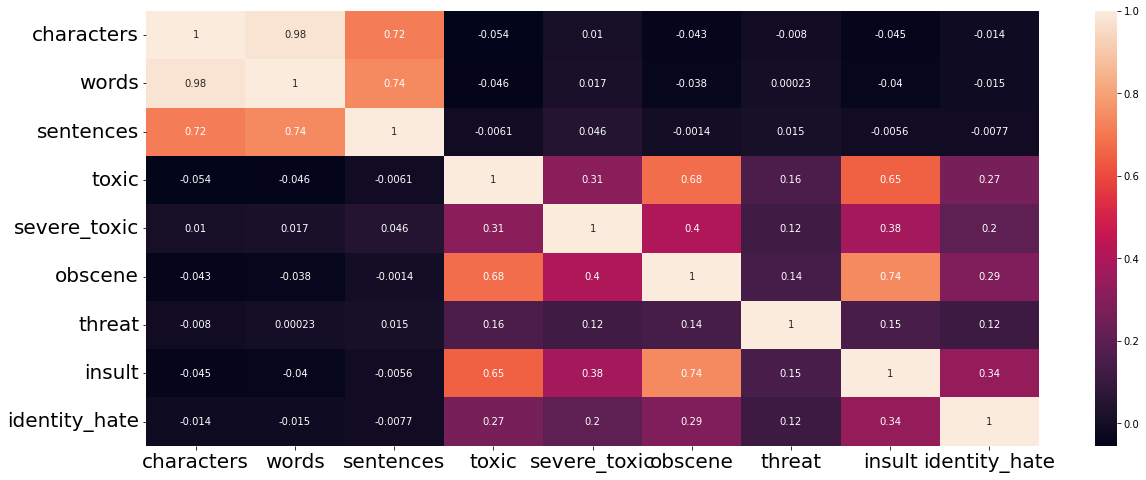

In [89]:
plt.figure(figsize=(20,8))
sns.heatmap(dftr.corr(),annot=True)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

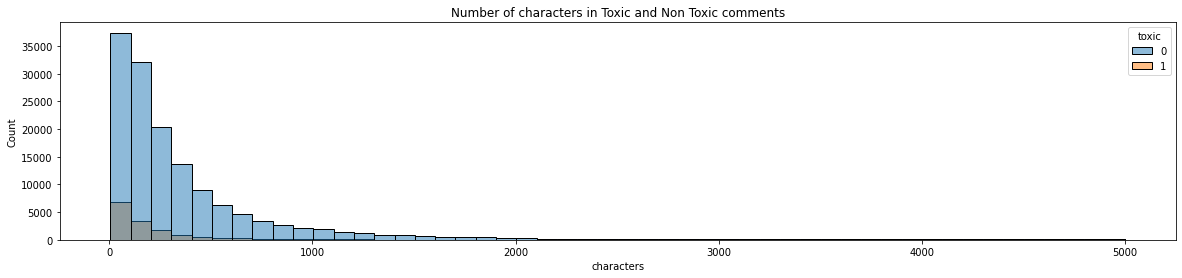

In [88]:
plt.figure(figsize=(20,4))
sns.histplot(data=dftr,x="characters",hue="toxic",bins=50)
plt.title("Number of characters in Toxic and Non Toxic comments")
plt.show()

<AxesSubplot:xlabel='characters', ylabel='words'>

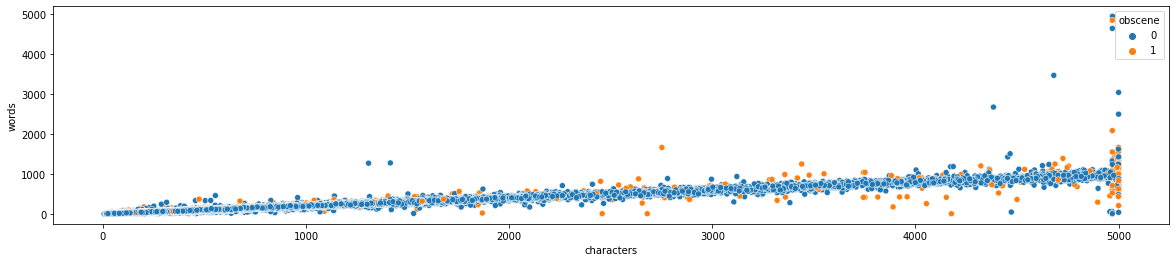

In [96]:
plt.figure(figsize=(20,4))
sns.scatterplot(data=dftr,x="characters",y="words",hue="obscene")

In [97]:
from wordcloud import WordCloud
wcobj = WordCloud(width=1000,height=1000,min_font_size=10,background_color="blue")
wc = wcobj.generate(x["comment_text"].str.cat(sep=" "))

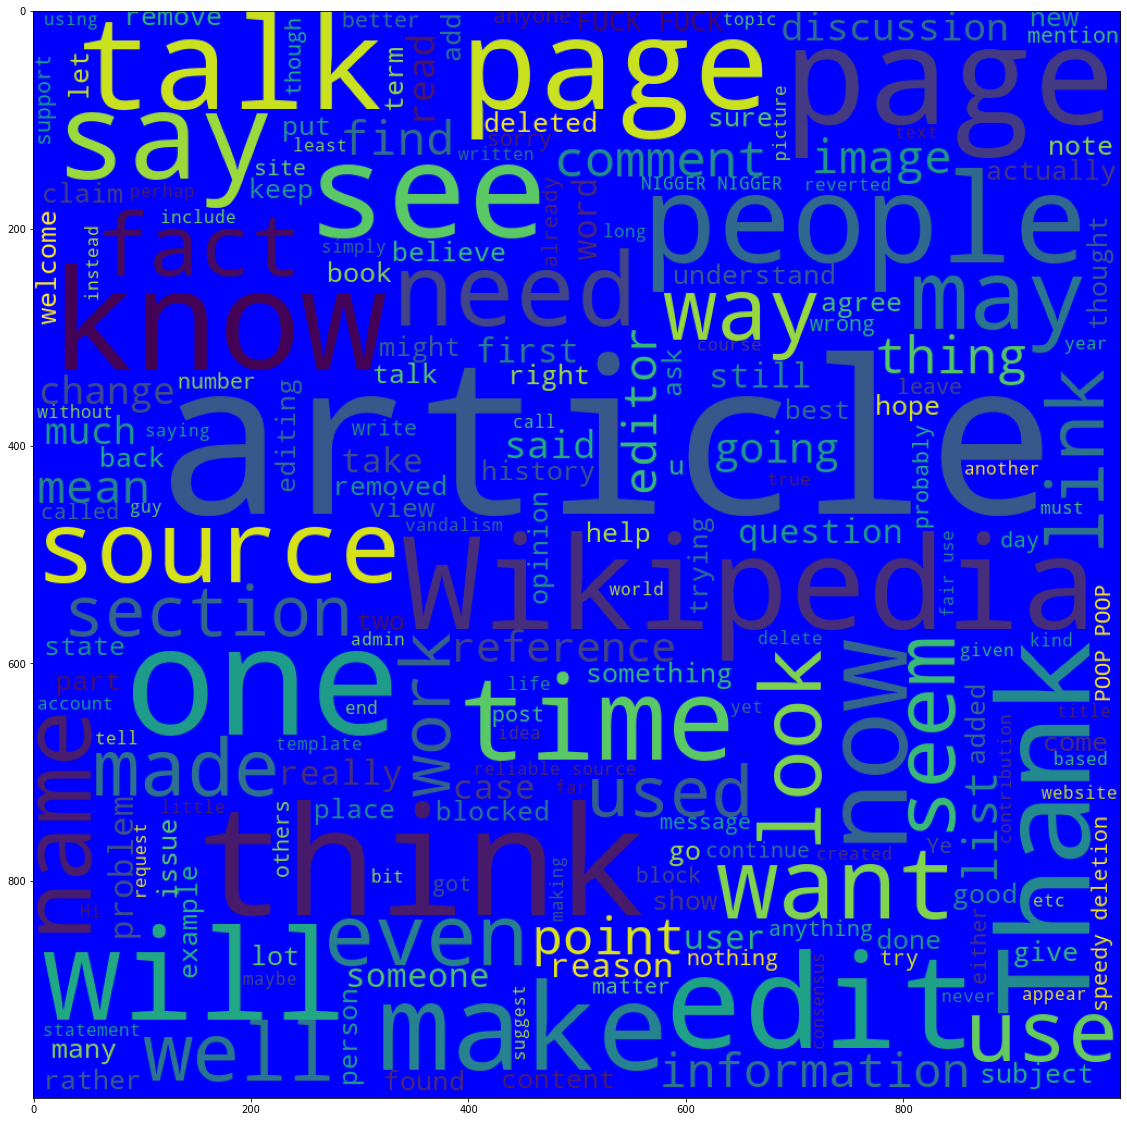

In [100]:
plt.figure(figsize=(20,20))
plt.imshow(wcobj)

Text(0.5, 1.0, 'identity_hate')

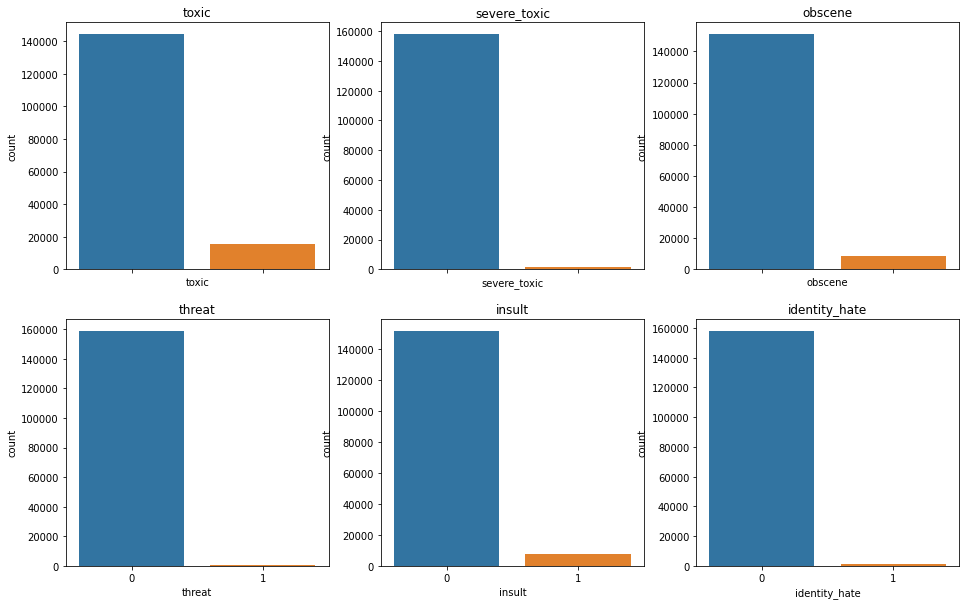

In [124]:
li = dftr.columns
fig,axes=plt.subplots(2,3,sharex=True,figsize=(16,10))
sns.countplot(ax=axes[0,0],data=dftr, x=li[3])
axes[0,0].set_title(li[3])
sns.countplot(ax=axes[0,1],data=dftr, x=li[4])
axes[0,1].set_title(li[4])
sns.countplot(ax=axes[0,2],data=dftr, x=li[5])
axes[0,2].set_title(li[5])
sns.countplot(ax=axes[1,0],data=dftr, x=li[6])
axes[1,0].set_title(li[6])
sns.countplot(ax=axes[1,1],data=dftr, x=li[7])
axes[1,1].set_title(li[7])
sns.countplot(ax=axes[1,2],data=dftr, x=li[8])
axes[1,2].set_title(li[8])

# Text Preprocessing

In [4]:
def convert(p):
    p=re.sub("[^a-zA-Z]"," ",p)
    p=p.lower()
    p=nltk.word_tokenize(p)
    corpus=[]
    for a in p:
        if a.isalnum():
            corpus.append(a)
    corpus3=[]
    for a in corpus:
        corpus3.append(ps.stem(a))
    return " ".join(corpus3)

In [5]:
%%time
x["t_text"] = x["comment_text"].apply(convert)

CPU times: user 8min, sys: 1.1 s, total: 8min 1s
Wall time: 8min 3s


In [6]:
x.head()

,comment_text,t_text
0,Explanation\nWhy the edits made under my usern...,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,d aww he match thi background colour i m seemi...
2,"Hey man, I'm really not trying to edit war. It...",hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero ani chanc you rememb what ...


# Feature Engineering

In [9]:
%%time
cv = CountVectorizer(max_features=800,ngram_range=(1,1))
dff = pd.DataFrame(cv.fit_transform(x.t_text).toarray())
dff.columns=cv.get_feature_names()

In [51]:
wo = stopwords.words("english")
for a in dff.columns:
    if a in wo:
        dff.drop(a,inplace=True,axis=1)

In [52]:
dff.shape

(312735, 892)

In [12]:
xtr = dff.iloc[:159571]
xte = dff.iloc[159571:]
xtr.shape,xte.shape

((159571, 1000), (153164, 1000))

In [14]:
y.shape

(159571, 6)

# Model Building

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
%%time
model1=DecisionTreeClassifier()
model1.fit(xtr,y)

CPU times: user 6min 53s, sys: 846 ms, total: 6min 53s
Wall time: 6min 55s


RandomForestClassifier()

In [ ]:
%%time
model2=KNeighborsClassifier()
model2.fit(xtr,y)

In [ ]:
%%time
model3=RandomForestClassifier()
model3.fit(xtr,y)

In [42]:
%%time
ypred1 = model1.predict(xte)

In [ ]:
%%time
ypred2 = model2.predict(xte)

In [ ]:
%%time
ypred3 = model3.predict(xte)

In [44]:
ypred1=pd.DataFrame(ypred1,columns=["toxic","severe_toxic","obscene","threat","insult","identity_hate"])
ypred2=pd.DataFrame(ypred2,columns=["toxic","severe_toxic","obscene","threat","insult","identity_hate"])
ypred3=pd.DataFrame(ypred3,columns=["toxic","severe_toxic","obscene","threat","insult","identity_hate"])

In [46]:
test1 = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip")
ypred1["id"]=test1.id
ypred1=ypred1.iloc[:,[-1,0,1,2,3,4,5]]
ypred2["id"]=test1.id
ypred2=ypred2.iloc[:,[-1,0,1,2,3,4,5]]
ypred3["id"]=test1.id
ypred3=ypred3.iloc[:,[-1,0,1,2,3,4,5]]
ypred1.to_csv("DecisionTree.csv",index=False)
ypred2.to_csv("KNN.csv",index=False)
ypred3.to_csv("RF.csv",index=False)